## ASSIGNMENT 5

#### https://www.kaggle.com/code/freespirit08/time-series-for-beginners-with-arima/data

Download dataset from above link, you will predict time series.


# Time Series Assignment 

In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA  
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Data understanding

In [3]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
# changing the coloumn names
df.columns = ['Month','Passengers']

In [6]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
# Converting month column into datatime data type 

df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
print('Years : ',df['Month'].dt.year.unique())
print('no of Years : ',df['Month'].dt.year.nunique())

Years :  [1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960]
no of Years :  12


* we have used 12 years of passengers data which ranges from 1949 to 1960 

In [8]:
#Data Cleaning if required

In [9]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

### Data visiualization

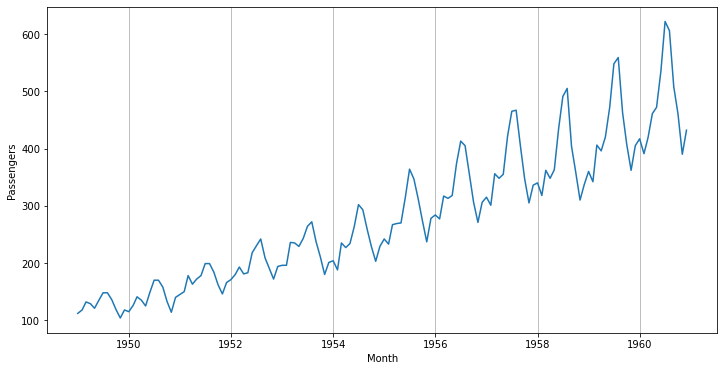

In [10]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df['Month'],y=df['Passengers'])
plt.grid(axis='x')
plt.show()

* From the plot we can see that the data is seasonal an there is a trend  , The cures seams to be indentically increasing as at the start of every year the curve starts to increase, summer season (march - may) the values rech thier highest peak and in the wintwe and rainy season which comes after summer there is drastic drop in the passengers onboarding the flight

In [11]:
data = df.copy()

In [12]:
data.set_index(['Month'],inplace=True)

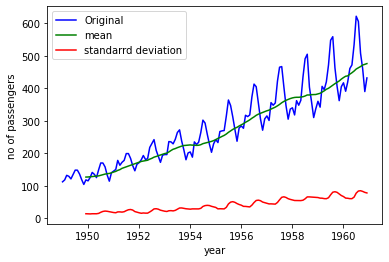

In [13]:
# to check foe stationarity we plot rolling statistics

roll_mean = data.rolling(window=12).mean()
roll_std = data.rolling(window=12).std()

plt.plot(data,color='blue',label='Original')
plt.plot(roll_mean,color='green',label='mean')
plt.plot(roll_std,color='red',label='standarrd deviation')
plt.legend()
plt.xlabel('year')
plt.ylabel('no of passengers')
plt.show()

* For a time series to be stationary it should follow most two criterion i.e the mean and std to be constant with time or mean and std is invariant over time. Curves conclude that data is not stationary
* to build a time series model the data should be stationary
* we perform augmented dickey-fuller test 

In [14]:
print('results of dickey-fuller test')
dftest = adfuller(data['Passengers'],autolag='AIC')
df_res = pd.Series(dftest[:4],index=['Test statistic','p value','Lags used','no of observations used'])
for key,value in dftest[4].items():
    df_res[f'critical {key}'] = value
df_res        

results of dickey-fuller test


Test statistic               0.815369
p value                      0.991880
Lags used                   13.000000
no of observations used    130.000000
critical 1%                 -3.481682
critical 5%                 -2.884042
critical 10%                -2.578770
dtype: float64

* For a time series to be stationary :
  * p values should be less than 0.05
  * critical values of 1%,5%,10% should be close to test statistic value
* From the results we conclude the time series is not stationary

### Data Transformation to achieve stationarity

In [15]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

##### 1. Log Transformation

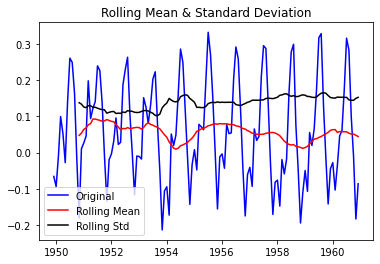

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [16]:
log_data = np.log(data)
moving_average = log_data.rolling(window=12).mean()
log_ma_data = log_data - moving_average
log_ma_data.dropna(inplace=True)

# test for stationarity
test_stationarity(log_ma_data)

* The p value is 0.222 which is greater than 0.05
* The critical values are almost equal to the test statistic 
  * We call the series to be stationary 

##### 2. Exponential Decay

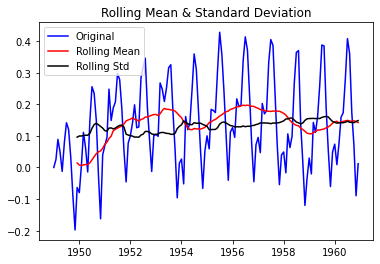

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
# we perform exponential deacy ro the log scaled data to reduce p value
exponential_decay_weighted_average = log_data.ewm(halflife=12,min_periods=0,adjust=True).mean()
log_exp_data = log_data - exponential_decay_weighted_average

#test for stationarity
test_stationarity(log_exp_data)

* The p values is impressive
* the critical values for eponential deccay is not close enough 

##### 3. Time Shift Transformation

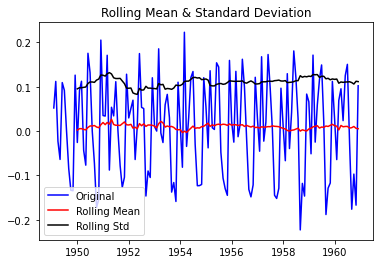

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [18]:
log_diffshift_data = log_data - log_data.shift()
log_diffshift_data.dropna(inplace=True)
test_stationarity(log_diffshift_data)

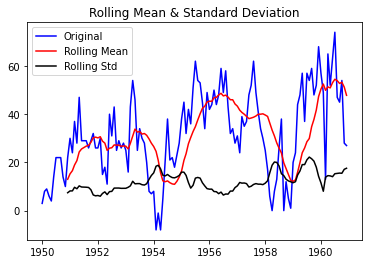

Results of Dickey Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [19]:
diff_shift_data = data - data.shift(12)
diff_shift_data.dropna(inplace=True)
test_stationarity(diff_shift_data)

* p values is less than 0.05 
* the critical values are better than exponential decay

# Model building

'''
ARIMA
'''

+ ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

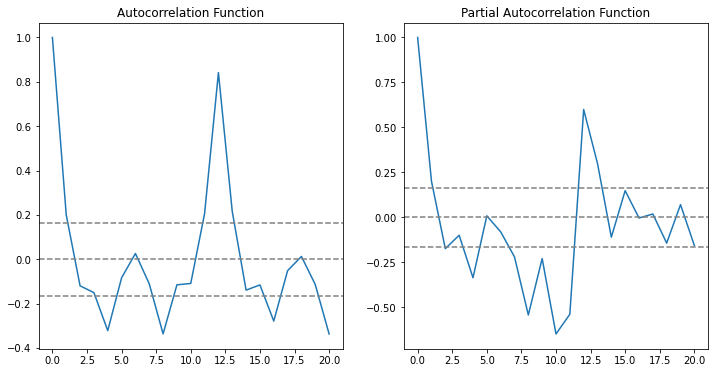

In [20]:
lag_acf = acf(log_diffshift_data,nlags=20)
lag_pacf = pacf(log_diffshift_data,nlags=20,method='ols')

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diffshift_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_diffshift_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')  

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diffshift_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_diffshift_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

* From the above graph from acf plot we see the curves y=0 at x=2 so Q = 2
* Fron pacf plot, the curve reaches y=0 at x=2 so P=2
* d=1

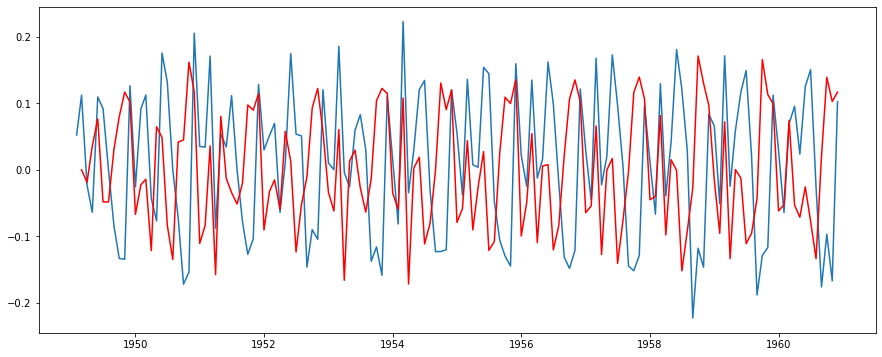

In [21]:
# ARIMA model
# order = (2,1,2)

model = ARIMA(log_diffshift_data,order=(2,1,2))
results_arima = model.fit()
plt.figure(figsize=(15,6))
plt.plot(log_diffshift_data)
plt.plot(results_arima.fittedvalues,color='red')


### prediction 

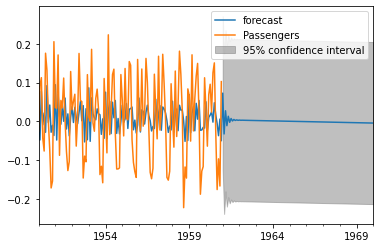

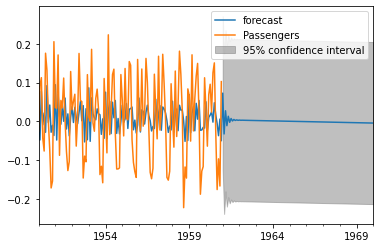

In [42]:
results_arima.plot_predict('1950', '1970') 